In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import datetime
import gc  # garbage collect to reduce memory use
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

In [2]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")
print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Torch version:  2.3.0
GPU Available: False


In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, factor_dim):
        super(Autoencoder, self).__init__()

        # Beta side (1 hidden layer as an example)
        self.beta_fc1 = nn.Linear(input_dim, 100, bias=False)
        self.beta_bn1 = nn.BatchNorm1d(100)
        self.beta_bn2 = nn.BatchNorm1d(100)
        self.beta_fc2 = nn.Linear(100, factor_dim, bias=False)

        self.beta_fc3 = nn.Linear(input_dim, 100, bias=False)
        self.beta_fc4 = nn.Linear(100, factor_dim, bias=False)
        self.layernorm1 = nn.LayerNorm(100, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(100, eps=1e-6)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.3)

        # Factor side
        self.factor_fc1 = nn.Linear(input_dim, factor_dim, bias=False)

    def forward(self, firm_chars, portfolios):
        # Beta side
        x = F.relu(self.beta_bn1(self.beta_fc1(firm_chars)))

        #x = self.dropout1(self.beta_fc2(x))

        x = self.dropout1(self.beta_fc2(x))

        x = torch.squeeze(x)

        # Factor side
        y = F.relu(self.beta_bn2(self.beta_fc3(portfolios)))

        #y = self.dropout2(self.beta_fc4(y))
        y = self.dropout2(self.beta_fc4(y))

        y = torch.squeeze(y)

        # print(y.shape, x.shape)

        # Dot product
        out = torch.sum(x * y, dim=1)

        return x, y, out

In [4]:
def train_ae(model, criterion, train_loader, optimizer, l1_lambda, device):
    # activate the training mode
    model.train()
    torch.set_grad_enabled(True)
    total_loss = 0

    # iteration over the mini-batches
    for batch_idx, (firm_chars, portfolios, target) in enumerate(train_loader):
        # transfer the data on the chosen device
        firm_chars, portfolios, target = firm_chars.to(device), portfolios.to(device), target.to(device)

        # reinitialize the gradients to zero
        optimizer.zero_grad()

        # forward propagation on the data
        beta, factor, prediction = model(firm_chars, portfolios)

        # compute the cost function w.r.t. the targets
        loss = criterion(prediction, target)

        # add l1 regularization to loss function
        l1_norm = torch.linalg.norm(model.beta_fc1.weight, ord=1) + torch.linalg.norm(model.beta_fc2.weight, ord=1) + torch.linalg.norm(model.factor_fc1.weight, ord=1)
        loss += l1_lambda * l1_norm

        # execute the backpropagation
        loss.backward()

        # execute an optimization step
        optimizer.step()

        # accumulate the loss
        total_loss += loss.item() * len(firm_chars)

    # compute the average cost per epoch
    mean_loss = total_loss / len(train_loader.dataset)

    return mean_loss


In [5]:
def evaluate_ae(model, criterion, eval_loader, device):
    # activate the evaluation mode
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch_idx, (firm_chars, portfolios, target) in enumerate(eval_loader):
            # transfer the data on the chosen device
            firm_chars, portfolios, target = firm_chars.to(device), portfolios.to(device), target.to(device)

            # forward propagation on the data
            beta, factor, prediction = model(firm_chars, portfolios)

            # compute the cost function w.r.t. the targets
            loss = criterion(prediction, target)

            # accumulate the loss
            total_loss += loss.item() * len(firm_chars)

    # compute the average cost per epoch
    mean_loss = total_loss / len(eval_loader.dataset)

    return mean_loss


In [6]:
def ae_learning_loop(ensemble, input_size, factor_size, batch_size, num_epoch,
                     l1_lambda, learning_rate, train_dataset, val_dataset, test_dataset,
                     patience, device):

    output_name = 'best_model_ae.pth'
    mean_pred = np.zeros((test_dataset[0].shape[0], ensemble))

    for i in range(ensemble):
        # accumulators of average costs obtained per epoch
        train_losses = []
        val_losses = []

        # model definition
        model = Autoencoder(input_size, factor_size)
        model = model.to(device)

        # loss function
        criterion = nn.MSELoss()

        # optimizer definition
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # create mini-batches
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # learning loop
        min_val_loss = np.inf  # for early stopping, record the minimum validation loss
        num_no_improve = 0  # record the number of epochs with no improvements

        for epoch in range(num_epoch):
            # train the model
            train_loss = train_ae(model, criterion, train_loader, optimizer, l1_lambda, device)

            # get the validation loss
            val_loss = evaluate_ae(model, criterion, val_loader, device)

            # Save the costs obtained
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            # early stopping
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                num_no_improve = 0

                # save the best model
                torch.save(model.state_dict(), output_name)
            else:
                num_no_improve += 1

            if num_no_improve >= patience:
                break

        model.load_state_dict(torch.load(output_name))  # load the best model
        model.eval()
        firm_chars, portfolios = test_dataset[0], test_dataset[1]
        beta, factor, prediction = model(firm_chars, portfolios)  # get the OOS prediction
        mean_pred[:, i] = prediction.cpu().data.numpy()

    # compute the mean predictions across ensembles
    mean_pred = mean_pred.mean(axis=1)
    return mean_pred

In [7]:
 # for timing purpose
print(datetime.datetime.now())

# turn off Setting with Copy Warning
pd.set_option('mode.chained_assignment', None)

# read sample data
file_path = '/Users/aladelca/Downloads/homework_sample_small.csv'
raw = pd.read_csv(file_path, parse_dates=['date'], low_memory=False)
raw = raw.drop(columns=['date'])
raw['day'] = 1
raw['date'] = pd.to_datetime(raw[['year', 'month', 'day']])  # first day of the return month
raw = raw.drop(columns=['day'])
raw = raw[raw['stock_exret'].notna()]
gc.collect()

# read list of predictors
file_path = '/Users/aladelca/Downloads/factors_char_list1.csv'
var_list = list(pd.read_csv(file_path)['variable'].values)
binary_vars = ['convind', 'divi', 'divo', 'rd', 'securedind', 'sin']

2024-06-15 11:42:58.528647


In [8]:
raw.drop(['zero_trades_126d'],axis=1, inplace= True)

In [9]:
raw.head()

,ret_eom,permno,stock_ret,mspread,year,month,sizeport,roeport,me,prc,...,betabab_1260d,rmax5_rvol_21d,age,qmj,qmj_prof,qmj_growth,qmj_safety,rf,stock_exret,date
0,20050131,10012,-0.320388,0.031502,2005,1,S,V,24.443959,1.030000,...,3.252622,3.413290,240,-1.704654,-1.537990,-1.728815,-1.419387,0.0016,-0.321988,2005-01-01
1,20050131,10025,0.277966,0.006849,2005,1,S,P,123.973750,14.750000,...,0.355911,3.058774,240,-1.338785,-0.574028,-1.094585,-1.091335,0.0016,0.276366,2005-01-01
2,20050131,10026,-0.015909,0.012113,2005,1,S,V,442.348649,49.029999,...,0.811736,0.902699,240,1.095448,1.392309,-0.813281,1.475873,0.0016,-0.017509,2005-01-01
3,20050131,10028,-0.063830,0.015489,2005,1,S,V,13.854660,2.820000,...,0.954925,1.518679,240,-0.159205,-0.354419,1.169657,-0.993571,0.0016,-0.065430,2005-01-01
4,20050131,10032,-0.114527,0.010306,2005,1,S,V,562.019000,13.010000,...,2.608261,0.734373,228,-1.437156,-1.493778,-1.581260,-0.094867,0.0016,-0.116127,2005-01-01


In [10]:
var_list.remove('zero_trades_126d')

In [11]:
panel = raw.pivot_table(index = 'date', columns = 'permno', values = 'stock_exret', aggfunc = lambda x:x)

<Axes: xlabel='date'>

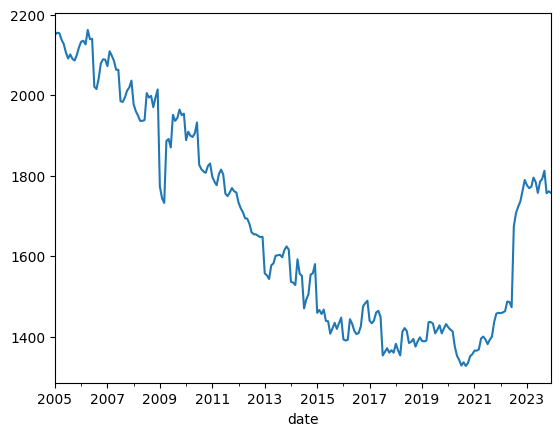

In [12]:
np.invert(panel.isna()).sum(1).plot()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


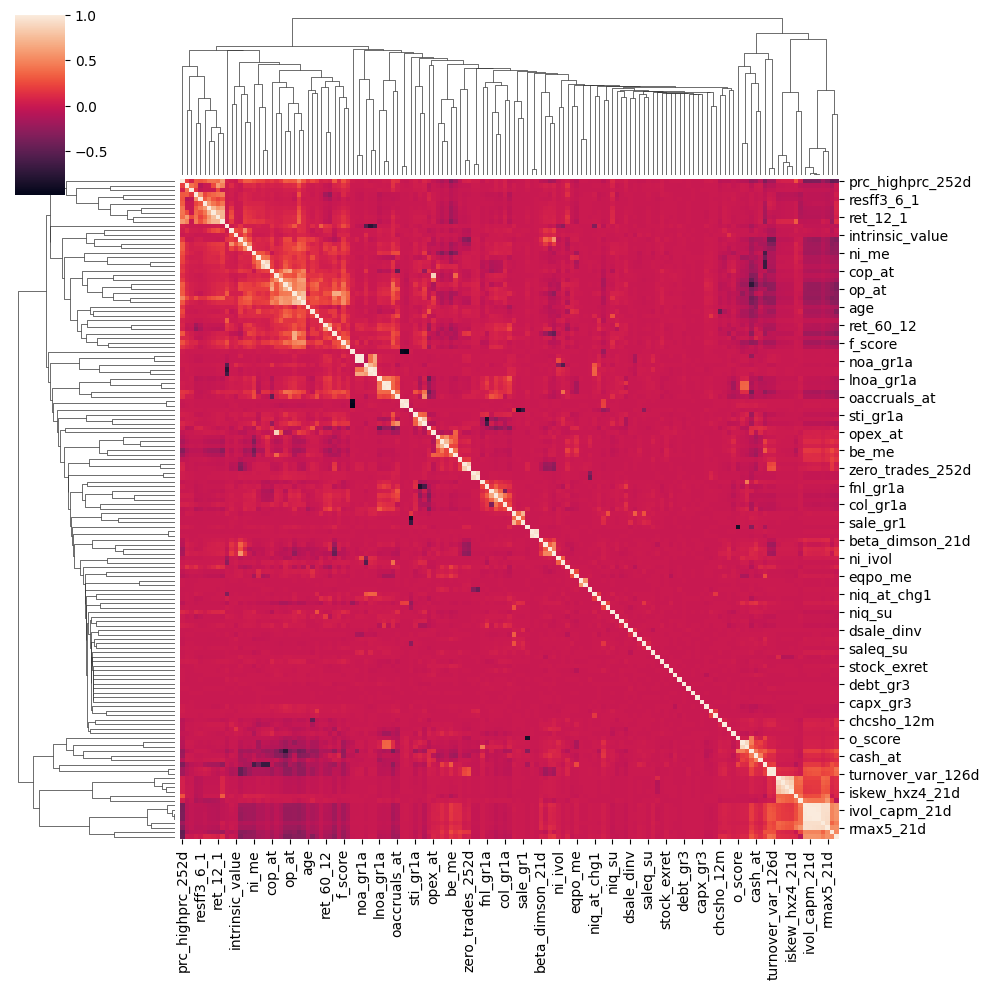

In [15]:
sns.clustermap(raw[var_list+['stock_exret']].corr())

In [13]:
# transform each variable in each month
monthly = raw.groupby('date')
adj_raw = pd.DataFrame()
for date, monthly_raw in monthly:
    group = monthly_raw.copy()
    # rank transform each variable to [-1, 1]
    for var in var_list:
        var_median = group[var].median(skipna=True)
        group[var] = group[var].fillna(var_median)

        if var in binary_vars:
            pass
        else:
            group[var] = group[var].rank(method='dense') - 1
            group_max = group[var].max()
            if group_max > 0:
                group[var] = (group[var] / group_max) * 2 - 1
            else:
                group[var] = 0  # in case of all missing values
                print('Warning:', date, var, 'set to zero.')

    # add the adjusted values
    adj_raw = pd.concat([adj_raw,group],axis = 0)
    gc.collect()

In [14]:
# add a constant to the list of characteristics
adj_raw['constant'] = 1
var_list.append('constant')
port_list = [var + '_port' for var in var_list]

# create managed portfolios for each month
monthly_adj = adj_raw.groupby('date')
data = pd.DataFrame()
for date, group in monthly_adj:
    expand = group.copy()
    Zt = group[var_list].values
    Rt = group['stock_exret'].values
    Xt = LinearRegression(fit_intercept=False).fit(Zt, Rt).coef_
    X_port = pd.DataFrame(data=[Xt], columns=port_list)
    expand = pd.concat([expand.reset_index(drop=True), X_port.reset_index(drop=True)], axis=1)

    # print(expand.shape)
    # print(expand.head())


    expand.ffill(inplace=True)
    data = pd.concat([data,expand],axis=0)
    gc.collect()

/var/folders/3s/3k3nlxhn13nfv9vncl9g9kbr0000gn/T/ipykernel_57252/336586901.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adj_raw['constant'] = 1


In [18]:
X_port.shape

(1, 147)

In [19]:
Xt.shape

(147,)

In [20]:
Zt.shape

(1757, 147)

In [21]:
X_port.shape

(1, 147)

In [22]:
# estimation with expanding window

# initialize
starting = pd.to_datetime('20050101', format="%Y%m%d")
counter = 0
pred_out = pd.DataFrame()



In [23]:
while (starting + pd.DateOffset(years= 12 + counter)) <= pd.to_datetime('20200101', format='%Y%m%d'):
    cutoff = [starting, starting + pd.DateOffset(years=10 + counter),
                starting + pd.DateOffset(years=12 + counter),
                starting + pd.DateOffset(years=31 + counter)]

    # cut the sample into training, validation, and testing sets
    train = data[(data['date'] >= cutoff[0]) & (data['date'] < cutoff[1])]
    validate = data[(data['date'] >= cutoff[1]) & (data['date'] < cutoff[2])]
    test = data[(data['date'] >= cutoff[2]) & (data['date'] < cutoff[3])]



    # get Xs and Ys and Zs
    Z_train = train[var_list].values
    X_train = train[port_list].values
    Y_train = train['stock_exret'].values

    Z_val = validate[var_list].values
    X_val = validate[port_list].values
    Y_val = validate['stock_exret'].values

    Z_test = test[var_list].values
    X_test = test[port_list].values
    Y_test = test['stock_exret'].values

    #print(Z_train)

    # prepare output data
    pred_batch = test[['year', 'month', 'date', 'permno', 'stock_exret']]

    # load data into tensor datasets (firm_chars, portfolios, target)
    train_dataset = TensorDataset(torch.from_numpy(Z_train).float(), torch.from_numpy(X_train).float(), torch.from_numpy(Y_train).float())
    val_dataset = TensorDataset(torch.from_numpy(Z_val).float(), torch.from_numpy(X_val).float(), torch.from_numpy(Y_val).float())
    Z_test = torch.from_numpy(Z_test).float()
    Z_test = Z_test.to(device)
    X_test = torch.from_numpy(X_test).float()
    X_test = X_test.to(device)
    test_dataset = (Z_test, X_test)

    # define some general variables for nn
    batch_size = 10000
    num_epoch = 100
    patience = 5
    ensemble = 10
    input_size = len(var_list)
    factor_size = 15  # could be a hyperparameter
    l1_lambda = 0.0001  # could be a hyperparameter
    learning_rate = 0.001  # could be a hyperparameter

    pred_batch['ae'] = ae_learning_loop(ensemble, input_size, factor_size, batch_size, num_epoch,
                                        l1_lambda, learning_rate, train_dataset, val_dataset, test_dataset,
                                        patience, device)

    # add to the output data
    pred_out = pd.concat([pred_out,pred_batch], axis = 0)

    # go to the next year
    counter += 1

    # for timing purpose
    print(datetime.datetime.now())


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-06-15 10:12:21.130462


KeyboardInterrupt: 

In [ ]:
# print the OOS Total R2
yreal = pred_out['stock_exret'].values
ypred = pred_out['ae'].values
r2 = 1 - np.sum(np.square((yreal - ypred))) / np.sum(np.square(yreal))
print(r2)

0.015764807417151583


In [162]:
pred_out[['stock_exret','ae']].corr()

,stock_exret,ae
stock_exret,1.000000,0.214065
ae,0.214065,1.000000


<Axes: >

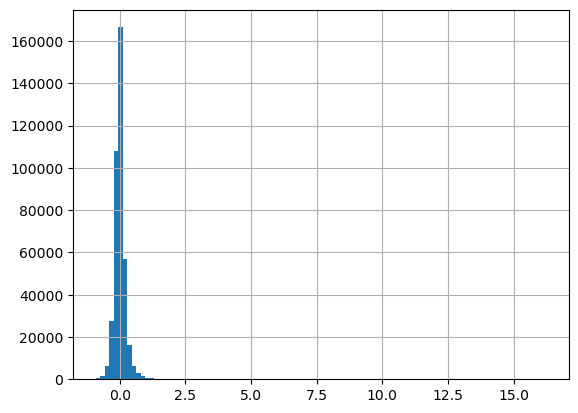

In [ ]:
pred_out['stock_exret'].hist(bins = 100)

<Axes: >

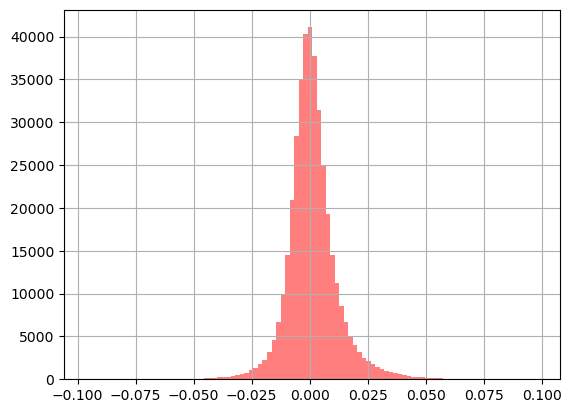

In [ ]:
pred_out['ae'].hist(bins = 100, alpha = 0.5, color = 'r')

In [ ]:
pred_out.to_csv('pred_out.csv')

In [3]:
pred_out = pd.read_csv('pred_out.csv')

In [70]:
top_50 = pd.DataFrame()
for d in pred_out['date'].unique():

    top_50 = pd.concat([top_50, pred_out[pred_out.date == d].sort_values('ae', ascending = False).iloc[:1]],axis = 0)

In [71]:
rnd = pd.DataFrame()
for d in pred_out['date'].unique():

    rnd = pd.concat([rnd, pred_out[pred_out.date == d].sort_values('ae',ascending = False).iloc[:100].sample(50, replace= False)],axis = 0)

In [72]:
rnd_50 = pd.DataFrame()
for d in pred_out['date'].unique():

    rnd_50 = pd.concat([rnd_50, pred_out[pred_out.date == d].sort_values('ae',ascending = False).iloc[:500].sample(50, replace= False)],axis = 0)

In [15]:
rnd_50.head()

,Unnamed: 0,year,month,date,permno,stock_exret,ae
876,876,2017,1,2017-01-01,81566,-0.002622,0.006635
570,570,2017,1,2017-01-01,25304,-0.018782,0.006316
287,287,2017,1,2017-01-01,14451,-0.140342,0.007949
841,841,2017,1,2017-01-01,80054,0.012571,0.006931
319,319,2017,1,2017-01-01,14556,-0.142240,0.004925


In [7]:
rnd['1+stock_exret'] = 1+rnd['stock_exret']
rnd['1+ae'] = 1+rnd['ae']

<Axes: xlabel='date'>

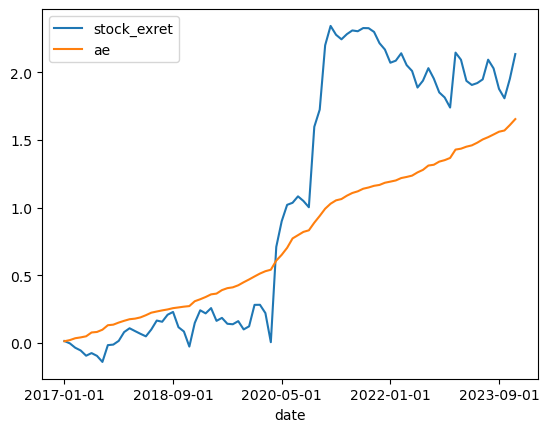

In [73]:
rnd.groupby('date')[['stock_exret','ae']].mean().cumsum().plot()

<Axes: xlabel='date'>

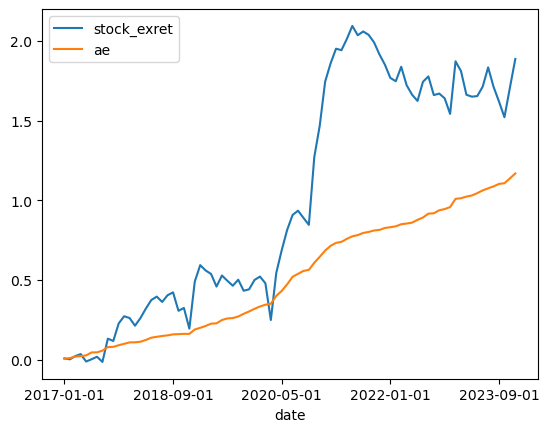

In [74]:
rnd_50['1+stock_exret'] = 1+rnd_50['stock_exret']
rnd_50['1+ae'] = 1+rnd_50['ae']

rnd_50.groupby('date')[['stock_exret','ae']].mean().cumsum().plot()

In [ ]:
top_50['1+stock_exret'] = 1+top_50['stock_exret']
top_50['1+ae'] = 1+top_50['ae']

<Axes: xlabel='date'>

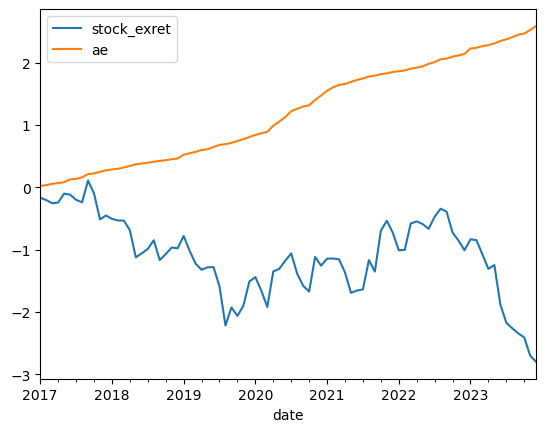

In [ ]:
top_50.groupby('date')[['stock_exret','ae']].mean().cumsum().plot()

In [8]:
spy = pd.read_csv('E:/Final Paper/SPY.csv', parse_dates = ['timestamp'])

In [9]:
spy.set_index('timestamp',inplace = True)

In [10]:
spy = spy[spy.index.is_month_start]
spy = spy.iloc[::-1]

In [11]:
spy

,Unnamed: 0,open,high,low,close,adjusted_close,volume,dividend,split
timestamp,,,,,,,,,
1999-11-01,6031,136.5000,137.000000,135.562500,135.562500,87.576805,4006500,0.0,1.0
1999-12-01,6010,139.3125,140.500000,139.000000,140.406204,90.705960,6980200,0.0,1.0
2000-02-01,5968,139.7500,141.687500,138.531204,140.937500,91.270965,8419900,0.0,1.0
2000-03-01,5948,137.6250,139.000000,137.218704,138.437500,89.651967,6868000,0.0,1.0
2000-05-01,5906,146.5625,148.484299,145.843704,147.062500,95.477856,7328300,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2023-03-01,162,395.4100,396.690000,393.380000,394.740000,390.366871,99706823,0.0,1.0
2023-05-01,120,415.4700,417.620000,415.265000,415.510000,412.493758,62122254,0.0,1.0
2023-06-01,98,418.0900,422.920000,416.790000,421.820000,418.757953,88865018,0.0,1.0


In [39]:
spy = np.log(spy['adjusted_close']/spy['adjusted_close'].shift(1))

In [11]:
# spy = spy['adjusted_close']/spy['adjusted_close'].shift(1)

In [20]:
rf = raw.groupby(['date'])['rf'].mean()

In [22]:
raw.columns

Index(['ret_eom', 'permno', 'stock_ret', 'mspread', 'year', 'month',
       'sizeport', 'roeport', 'me', 'prc',
       ...
       'betabab_1260d', 'rmax5_rvol_21d', 'age', 'qmj', 'qmj_prof',
       'qmj_growth', 'qmj_safety', 'rf', 'stock_exret', 'date'],
      dtype='object', length=158)

In [14]:
ret = raw[['date','permno','stock_ret']]

In [30]:
ret['date'] = ret['date'].astype('str')

In [27]:
rnd_50.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4200 entries, 876 to 394333
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   4200 non-null   int64  
 1   year         4200 non-null   int64  
 2   month        4200 non-null   int64  
 3   date         4200 non-null   object 
 4   permno       4200 non-null   int64  
 5   stock_exret  4200 non-null   float64
 6   ae           4200 non-null   float64
dtypes: float64(2), int64(4), object(1)
memory usage: 262.5+ KB


In [31]:
ret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381355 entries, 0 to 381354
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       381355 non-null  object 
 1   permno     381355 non-null  int64  
 2   stock_ret  381355 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.7+ MB


In [75]:
rnd_50 = rnd_50.merge(ret, left_on=['date','permno'], right_on=['date','permno'], how='left')


In [76]:
top_50 = top_50.merge(ret, left_on=['date','permno'], right_on=['date','permno'], how='left')

In [77]:
rnd = rnd.merge(ret, left_on=['date','permno'], right_on=['date','permno'], how='left')

In [78]:
rnd_50['date'] = pd.to_datetime(rnd_50['date'], format = "%Y-%m-%d")

In [79]:
top_50['date'] = pd.to_datetime(top_50['date'], format = "%Y-%m-%d")

In [80]:
rnd['date'] = pd.to_datetime(rnd['date'], format = "%Y-%m-%d")

In [85]:
combined  = pd.concat([top_50.groupby('date')['stock_ret'].mean().rename('top50'),
                       rnd.groupby('date')['stock_ret'].mean().rename('rand_50_out_of_top100'),
                       rnd_50.groupby('date')['stock_ret'].mean().rename('rand_50_out_of_top500'),
                       spy.rename('SPY'), rf],axis = 1).dropna()

# combined['SPY'] = combined['adjusted_close'].cumprod()

# combined[['top50', 'random_10', 'random_50','SPY']].plot()

<Axes: >

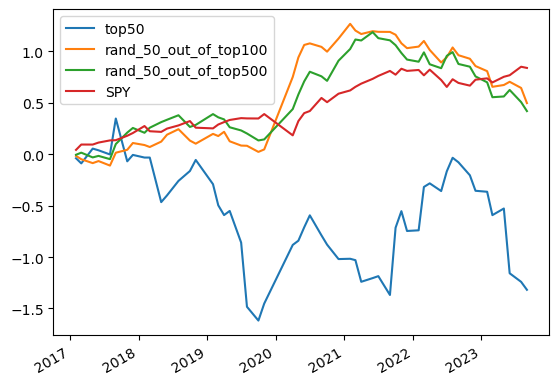

In [87]:
combined[['top50', 'rand_50_out_of_top100', 'rand_50_out_of_top500','SPY']].cumsum().plot()

In [21]:
def calculate_performance_statistics(returns):

    statistics = {}

    # Calculate maximum drawdown
    def max_drawdown(cum_returns):
        peak = cum_returns.cummax()
        drawdown = cum_returns - peak

        return drawdown.min()

    def cal_alpha(endog,exog):

        #exog = sm.add_constant(returns[['rf', 'SPY']])

        ols = sm.OLS(endog = endog, exog = exog).fit(cov_type = 'HAC', cov_kwds = {'maxlags':3}, use_t = True)
        alpha = float(ols.summary().tables[1].data[1][1])
        return alpha


    spy_returns  = returns['SPY']
    sharpe_ratio_spy = ((spy_returns-returns['rf']).mean() / spy_returns.std()) * np.sqrt(12)
    avg_return_spy = spy_returns.mean()
    std_dev_spy = spy_returns.std()

    #print(std_dev_spy)
    max_drawdown_spy = max_drawdown(spy_returns.cumsum())
    max_one_month_loss_spy = spy_returns.min()

    statistics['SPY'] = {'Alpha':0, 'Sharpe Ratio':sharpe_ratio_spy, 'Average Return':avg_return_spy,
                'Standard Deviation':std_dev_spy, 'Maximum Drawdown':max_drawdown_spy,'Maximum One-Month Loss':max_one_month_loss_spy}


    def cal_strat(strat):
        strategy_returns = returns[strat]
        # Calculate Alpha (difference in average return)
        strategy_cum_returns = returns[strat].cumsum()

        strategy_extret = returns[strat] - returns['rf']

        endog = strategy_extret
        exog = sm.add_constant(combined['SPY']-combined['rf'])

        alpha = cal_alpha(endog,exog)

        # Calculate Sharpe Ratio (annualized)
        sharpe_ratio_strategy = (strategy_extret.mean() / strategy_returns.std()) * np.sqrt(12)
        # Calculate average return
        avg_return_strategy = strategy_returns.mean()
        # Calculate standard deviation
        std_dev_strategy = strategy_returns.std()
        max_drawdown_strategy = max_drawdown(strategy_cum_returns)
        # Calculate maximum one-month loss
        max_one_month_loss_strategy = strategy_returns.min()

        return {'Alpha':alpha, 'Sharpe Ratio':sharpe_ratio_strategy, 'Average Return':avg_return_strategy,
                'Standard Deviation':std_dev_strategy, 'Maximum Drawdown':max_drawdown_strategy,'Maximum One-Month Loss':max_one_month_loss_strategy }

    for col in returns.columns:
        if col != 'SPY' and col !='rf':
            statistics[col] = cal_strat(col)

    return pd.DataFrame(statistics)



In [172]:
performance_statistics_multiple = calculate_performance_statistics(combined)


In [173]:
performance_statistics_multiple

,SPY,top50,rand_50_out_of_top100,rand_50_out_of_top500
Alpha,0.000000,-0.010500,0.016500,0.009900
Sharpe Ratio,0.889835,-0.379357,0.228677,0.256173
Average Return,0.015536,-0.024422,0.009203,0.007762
Standard Deviation,0.055751,0.234102,0.121003,0.088536
Maximum Drawdown,-0.207094,-1.965012,-0.770806,-0.767849
Maximum One-Month Loss,-0.207094,-0.629804,-0.152343,-0.144858


In [159]:
performance_statistics_multiple.to_excel('statistics.xlsx')

# APT

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import gc
import datetime

# Load data
file_path = 'E:/Final Paper/homework_sample_small.csv'
raw = pd.read_csv(file_path, parse_dates=['date'], low_memory=False)
raw = raw.drop(columns=['date'])
raw['day'] = 1
raw['date'] = pd.to_datetime(raw[['year', 'month', 'day']])
raw = raw.drop(columns=['day'])
raw = raw[raw['stock_exret'].notna()]
gc.collect()

file_path = 'E:/Final Paper/factors_char_list1.csv'
var_list = list(pd.read_csv(file_path)['variable'].values)
binary_vars = ['convind', 'divi', 'divo', 'rd', 'securedind', 'sin']

raw.drop(['zero_trades_126d'], axis=1, inplace=True)
var_list.remove('zero_trades_126d')

panel = raw.pivot_table(index='date', columns='permno', values='stock_exret', aggfunc=lambda x: x)

# Transform each variable in each month
monthly = raw.groupby('date')
adj_raw = pd.DataFrame()
for date, monthly_raw in monthly:
    group = monthly_raw.copy()
    for var in var_list:
        var_median = group[var].median(skipna=True)
        group[var] = group[var].fillna(var_median)
        if var not in binary_vars:
            group[var] = group[var].rank(method='dense') - 1
            group_max = group[var].max()
            if group_max > 0:
                group[var] = (group[var] / group_max) * 2 - 1
            else:
                group[var] = 0
    adj_raw = pd.concat([adj_raw, group], axis=0)
    gc.collect()

adj_raw['constant'] = 1
var_list.append('constant')
port_list = [var + '_port' for var in var_list]

monthly_adj = adj_raw.groupby('date')
data = pd.DataFrame()
for date, group in monthly_adj:
    expand = group.copy()
    Zt = group[var_list].values
    Rt = group['stock_exret'].values
    Xt = LinearRegression(fit_intercept=False).fit(Zt, Rt).coef_
    X_port = pd.DataFrame(data=[Xt], columns=port_list)
    expand = pd.concat([expand.reset_index(drop=True), X_port.reset_index(drop=True)], axis=1)
    expand.ffill(inplace=True)
    data = pd.concat([data, expand], axis=0)
    gc.collect()

# Function to train and evaluate the Linear Regression model
def train_evaluate_lr(train_data, val_data, test_data, var_list):
    Z_train = train_data[var_list].values
    Y_train = train_data['stock_exret'].values
    Z_val = val_data[var_list].values
    Y_val = val_data['stock_exret'].values
    Z_test = test_data[var_list].values
    Y_test = test_data['stock_exret'].values

    if len(Z_train) == 0 or len(Z_val) == 0 or len(Z_test) == 0:
        print("Empty dataset encountered, skipping this iteration.")
        return np.zeros(len(Y_val)), np.zeros(len(Y_test))

    lr_model = LinearRegression()
    lr_model.fit(Z_train, Y_train)

    val_pred = lr_model.predict(Z_val)
    test_pred = lr_model.predict(Z_test)

    val_rmse = np.sqrt(mean_squared_error(Y_val, val_pred))
    test_rmse = np.sqrt(mean_squared_error(Y_test, test_pred))
    print(f'Validation RMSE: {val_rmse}')
    print(f'Testing RMSE: {test_rmse}')

    return val_rmse, test_rmse, test_pred



C:\Users\tsong\AppData\Local\Temp\ipykernel_22180\4124553741.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adj_raw['constant'] = 1


In [4]:
# Initialize
starting = pd.to_datetime('20050101', format="%Y%m%d")
counter = 0
pred_out_lr = pd.DataFrame()
val_rmse_list = []
test_rmse_list = []

while (starting + pd.DateOffset(years=12 + counter)) <= pd.to_datetime('20200101', format='%Y%m%d'):
    cutoff = [starting, starting + pd.DateOffset(years=10 + counter),
              starting + pd.DateOffset(years=12 + counter),
              starting + pd.DateOffset(years=31 + counter)]

    train = adj_raw[(adj_raw['date'] >= cutoff[0]) & (adj_raw['date'] < cutoff[1])]
    validate = adj_raw[(adj_raw['date'] >= cutoff[1]) & (adj_raw['date'] < cutoff[2])]
    test = adj_raw[(adj_raw['date'] >= cutoff[2]) & (adj_raw['date'] < cutoff[3])]

    pred_batch_lr = test[['year', 'month', 'date', 'permno', 'stock_exret']]

    val_rmse, test_rmse, test_pred = train_evaluate_lr(train, validate, test, var_list)
    val_rmse_list.append(val_rmse)
    test_rmse_list.append(test_rmse)
    pred_batch_lr['lr'] = test_pred

    pred_out_lr = pd.concat([pred_out_lr, pred_batch_lr], axis=0)

    counter += 1
    print(datetime.datetime.now())

Validation RMSE: 0.19870639919822305
Testing RMSE: 0.2544993361826387
2024-06-10 00:18:46.305496


C:\Users\tsong\AppData\Local\Temp\ipykernel_22180\3390097522.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_batch_lr['lr'] = test_pred


Validation RMSE: 0.20327931983334427
Testing RMSE: 0.2626001248458009
2024-06-10 00:18:49.871327


C:\Users\tsong\AppData\Local\Temp\ipykernel_22180\3390097522.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_batch_lr['lr'] = test_pred


Validation RMSE: 0.1875979558217884
Testing RMSE: 0.2750195075840338
2024-06-10 00:18:53.370997


C:\Users\tsong\AppData\Local\Temp\ipykernel_22180\3390097522.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_batch_lr['lr'] = test_pred


Validation RMSE: 0.20390554402396163
Testing RMSE: 0.28539446249748457
2024-06-10 00:18:56.810832


C:\Users\tsong\AppData\Local\Temp\ipykernel_22180\3390097522.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_batch_lr['lr'] = test_pred


In [5]:
# Print the OOS Total R2 for Linear Regression model
yreal_lr = pred_out_lr['stock_exret'].values
ypred_lr = pred_out_lr['lr'].values
r2_lr = 1 - np.sum(np.square((yreal_lr - ypred_lr))) / np.sum(np.square(yreal_lr))
print(f'OOS Total R2 for Linear Regression: {r2_lr}')

# Print average RMSE
avg_val_rmse = np.mean(val_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
print(f'Average Validation RMSE: {avg_val_rmse}')
print(f'Average Testing RMSE: {avg_test_rmse}')

# Save the predictions to CSV
pred_out_lr.to_csv('pred_out_lr.csv', index=False)

OOS Total R2 for Linear Regression: 0.0010408685609870627
Average Validation RMSE: 0.19837230471932935
Average Testing RMSE: 0.26937835777748953


In [64]:
pred_out_lr = pd.read_csv('pred_out_lr.csv')
pred_out_lr.head()

,year,month,date,permno,stock_exret,lr
0,2017,1,2017-01-01,10028,-0.000400,0.005039
1,2017,1,2017-01-01,10044,0.075164,0.006732
2,2017,1,2017-01-01,10253,0.380981,0.045410
3,2017,1,2017-01-01,10258,-0.079496,0.012116
4,2017,1,2017-01-01,10259,0.016267,0.026944


<Axes: >

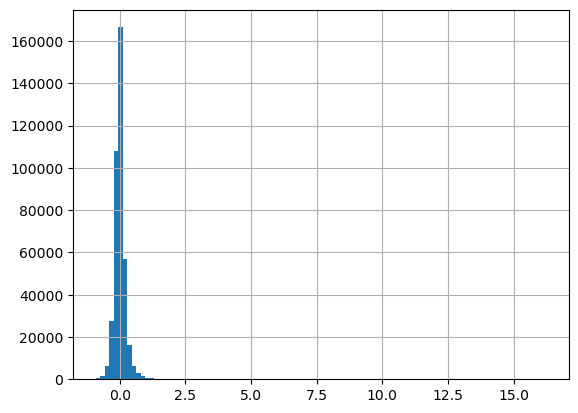

In [12]:
pred_out_lr['stock_exret'].hist(bins = 100)

<Axes: >

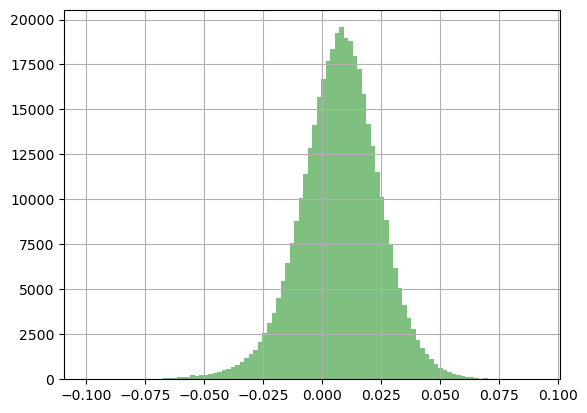

In [22]:
pred_out_lr['lr'].hist(bins = 100, alpha = 0.5, color = 'g')

In [163]:
pred_out_lr[['stock_exret','lr']].corr()

,stock_exret,lr
stock_exret,1.000000,0.038031
lr,0.038031,1.000000


In [65]:
top_50_APT = pd.DataFrame()
for d in pred_out_lr['date'].unique():

    top_50_APT = pd.concat([top_50_APT, pred_out_lr[pred_out_lr.date == d].sort_values('lr', ascending = False).iloc[:1]],axis = 0)


In [66]:
rnd_50_APT = pd.DataFrame()
for d in pred_out_lr['date'].unique():

    rnd_50_APT = pd.concat([rnd_50_APT, pred_out_lr[pred_out_lr.date == d].sort_values('lr',ascending = False).iloc[:500].sample(50, replace= False)],axis = 0)

In [67]:
top_50_APT = top_50_APT.merge(ret, left_on=['date','permno'], right_on=['date','permno'], how='left')

top_50_APT['date'] = pd.to_datetime(top_50_APT['date'], format = "%Y-%m-%d")

In [68]:
rnd_50_APT = rnd_50_APT.merge(ret, left_on=['date','permno'], right_on=['date','permno'], how='left')

rnd_50_APT['date'] = pd.to_datetime(rnd_50_APT['date'], format = "%Y-%m-%d")

<Axes: >

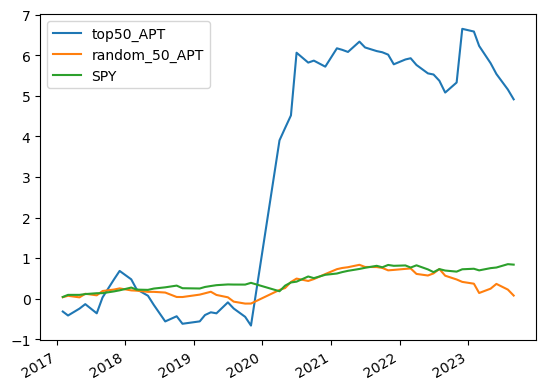

In [168]:
combined_APT  = pd.concat([top_50_APT.groupby('date')['stock_exret'].mean().rename('top50_APT'),
                       rnd_50_APT.groupby('date')['stock_exret'].mean().rename('random_50_APT'),
                       spy.rename('SPY'),rf],axis = 1).dropna()

# combined_APT['SPY'] = combined_APT['adjusted_close'].cumprod()

combined_APT[['top50_APT', 'random_50_APT','SPY']].cumsum().plot()

In [174]:
performance_statistics_APT = calculate_performance_statistics(combined_APT)


In [175]:
performance_statistics_APT

,SPY,top50_APT,random_50_APT
Alpha,0.000000,0.167800,0.003100
Sharpe Ratio,0.889835,0.433989,0.007920
Average Return,0.015536,0.090977,0.001427
Standard Deviation,0.055751,0.716480,0.092880
Maximum Drawdown,-0.207094,-1.736833,-0.757421
Maximum One-Month Loss,-0.207094,-0.424332,-0.229196


In [88]:
# def fibo(n):
#     if n == 0 or n== 1:
#         return 1
#     else:
#         return fibo(n-1)+fibo(n-2) 
       

In [89]:
# for i in range(18):
#     print(fibo(i))

### Catboost

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import gc
import datetime

# Load data
file_path = '/Users/aladelca/Downloads/homework_sample_small.csv'
raw = pd.read_csv(file_path, parse_dates=['date'], low_memory=False)
raw = raw.drop(columns=['date'])
raw['day'] = 1
raw['date'] = pd.to_datetime(raw[['year', 'month', 'day']])
raw = raw.drop(columns=['day'])
raw = raw[raw['stock_exret'].notna()]
gc.collect()

file_path = '/Users/aladelca/Downloads/factors_char_list1.csv'
var_list = list(pd.read_csv(file_path)['variable'].values)
binary_vars = ['convind', 'divi', 'divo', 'rd', 'securedind', 'sin']

raw.drop(['zero_trades_126d'], axis=1, inplace=True)
var_list.remove('zero_trades_126d')

panel = raw.pivot_table(index='date', columns='permno', values='stock_exret', aggfunc=lambda x: x)

# Transform each variable in each month
monthly = raw.groupby('date')
adj_raw = pd.DataFrame()
for date, monthly_raw in monthly:
    group = monthly_raw.copy()
    for var in var_list:
        var_median = group[var].median(skipna=True)
        group[var] = group[var].fillna(var_median)
        if var not in binary_vars:
            group[var] = group[var].rank(method='dense') - 1
            group_max = group[var].max()
            if group_max > 0:
                group[var] = (group[var] / group_max) * 2 - 1
            else:
                group[var] = 0
    adj_raw = pd.concat([adj_raw, group], axis=0)
    gc.collect()

adj_raw['constant'] = 1
var_list.append('constant')
port_list = [var + '_port' for var in var_list]

monthly_adj = adj_raw.groupby('date')
data = pd.DataFrame()
for date, group in monthly_adj:
    expand = group.copy()
    Zt = group[var_list].values
    Rt = group['stock_exret'].values
    Xt = LinearRegression(fit_intercept=False).fit(Zt, Rt).coef_
    X_port = pd.DataFrame(data=[Xt], columns=port_list)
    expand = pd.concat([expand.reset_index(drop=True), X_port.reset_index(drop=True)], axis=1)
    expand.ffill(inplace=True)
    data = pd.concat([data, expand], axis=0)
    gc.collect()





/var/folders/3s/3k3nlxhn13nfv9vncl9g9kbr0000gn/T/ipykernel_96917/2184265984.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adj_raw['constant'] = 1


KeyboardInterrupt: 

In [4]:
# Function to train and evaluate the Catboost
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
def train_evaluate_cb(train_data, val_data, test_data, var_list):
    Z_train = train_data[var_list].values
    Y_train = train_data['stock_exret'].values
    Z_val = val_data[var_list].values
    Y_val = val_data['stock_exret'].values
    Z_test = test_data[var_list].values
    Y_test = test_data['stock_exret'].values

    if len(Z_train) == 0 or len(Z_val) == 0 or len(Z_test) == 0:
        print("Empty dataset encountered, skipping this iteration.")
        return np.zeros(len(Y_val)), np.zeros(len(Y_test))

    lr_model = CatBoostRegressor(random_state=123, verbose=False)
    lr_model.fit(Z_train, Y_train)

    val_pred = lr_model.predict(Z_val)
    test_pred = lr_model.predict(Z_test)

    val_rmse = np.sqrt(mean_squared_error(Y_val, val_pred))
    test_rmse = np.sqrt(mean_squared_error(Y_test, test_pred))
    print(f'Validation RMSE: {val_rmse}')
    print(f'Testing RMSE: {test_rmse}')

    return val_rmse, test_rmse, test_pred

In [ ]:
# Initialize
starting = pd.to_datetime('20050101', format="%Y%m%d")
counter = 0
pred_out_catboost = pd.DataFrame()
val_rmse_list_cb = []
test_rmse_list_cb = []

while (starting + pd.DateOffset(years=12 + counter)) <= pd.to_datetime('20200101', format='%Y%m%d'):
    cutoff = [starting, starting + pd.DateOffset(years=10 + counter),
              starting + pd.DateOffset(years=12 + counter),
              starting + pd.DateOffset(years=31 + counter)]
    
    train = adj_raw[(adj_raw['date'] >= cutoff[0]) & (adj_raw['date'] < cutoff[1])]
    validate = adj_raw[(adj_raw['date'] >= cutoff[1]) & (adj_raw['date'] < cutoff[2])]
    test = adj_raw[(adj_raw['date'] >= cutoff[2]) & (adj_raw['date'] < cutoff[3])]

    pred_batch_cb = test[['year', 'month', 'date', 'permno', 'stock_exret']]

    val_rmse, test_rmse, test_pred = train_evaluate_cb(train, validate, test, var_list)
    val_rmse_list_cb.append(val_rmse)
    test_rmse_list_cb.append(test_rmse)
    pred_batch_cb['cb'] = test_pred

    pred_out_catboost = pd.concat([pred_out_catboost, pred_batch_cb], axis=0)

    counter += 1
    print(datetime.datetime.now())

In [16]:
# Print the OOS Total R2 for LGBM model
yreal_cb = pred_out_catboost['stock_exret'].values
ypred_cb = pred_out_catboost['cb'].values
r2_cb = 1 - np.sum(np.square((yreal_cb - ypred_cb))) / np.sum(np.square(yreal_cb))
print(f'OOS Total R2 for Catboost: {r2_cb}')

# Print average RMSE
avg_val_rmse_cb = np.mean(val_rmse_list_cb)
avg_test_rmse_cb = np.mean(test_rmse_list_cb)
print(f'Average Validation RMSE: {avg_val_rmse_cb}')
print(f'Average Testing RMSE: {avg_test_rmse_cb}')

# Save the predictions to CSV
pred_out_catboost.to_csv('pred_out_catboost.csv', index=False)

OOS Total R2 for Catboost: -0.009768284304519037
Average Validation RMSE: 0.20303199477367134
Average Testing RMSE: 0.27072878789494365


In [4]:
pred_out_cb = pd.read_csv('pred_out_catboost.csv')
pred_out_cb.head()

,year,month,date,permno,stock_exret,cb
0,2017,1,2017-01-01,10028,-0.000400,0.020428
1,2017,1,2017-01-01,10044,0.075164,0.015232
2,2017,1,2017-01-01,10253,0.380981,0.004931
3,2017,1,2017-01-01,10258,-0.079496,-0.020606
4,2017,1,2017-01-01,10259,0.016267,-0.002350


<Axes: >

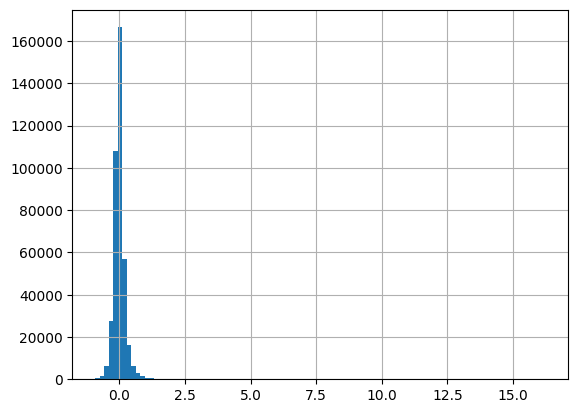

In [5]:
pred_out_cb['stock_exret'].hist(bins = 100)

<Axes: >

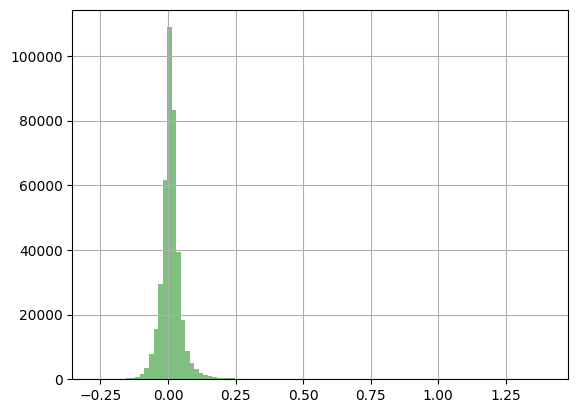

In [6]:
pred_out_cb['cb'].hist(bins = 100, alpha = 0.5, color = 'g')

In [7]:
top_50_APT = pd.DataFrame()
for d in pred_out_cb['date'].unique():

    top_50_APT = pd.concat([top_50_APT, pred_out_cb[pred_out_cb.date == d].sort_values('cb', ascending = False).iloc[:1]],axis = 0)


In [8]:
rnd_50_APT = pd.DataFrame()
for d in pred_out_cb['date'].unique():

    rnd_50_APT = pd.concat([rnd_50_APT, pred_out_cb[pred_out_cb.date == d].sort_values('cb',ascending = False).iloc[:500].sample(50, replace= False)],axis = 0)

In [9]:
raw[['date','permno','stock_ret']].dtypes
top_50_APT[['date','permno']]

,date,permno
1144,2017-01-01,89169
1572,2017-02-01,13279
3895,2017-03-01,86155
5353,2017-04-01,86155
6815,2017-05-01,86155
...,...,...
116820,2023-08-01,84302
118629,2023-09-01,84302
392137,2023-10-01,84302
393896,2023-11-01,84302


In [10]:
raw[['date','permno']]

,date,permno
0,2005-01-01,10012
1,2005-01-01,10025
2,2005-01-01,10026
3,2005-01-01,10028
4,2005-01-01,10032
...,...,...
381350,2023-12-01,93345
381351,2023-12-01,93371
381352,2023-12-01,93373
381353,2023-12-01,93397


In [11]:
ret = raw[['date','permno','stock_ret']]
ret['date'] = ret['date'].astype('str')
top_50_APT = top_50_APT.merge(ret, left_on=['date','permno'], right_on=['date','permno'], how='left')

top_50_APT['date'] = pd.to_datetime(top_50_APT['date'], format = "%Y-%m-%d")

/var/folders/3s/3k3nlxhn13nfv9vncl9g9kbr0000gn/T/ipykernel_96917/611952963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret['date'] = ret['date'].astype('str')


In [12]:
rnd_50_APT = rnd_50_APT.merge(ret, left_on=['date','permno'], right_on=['date','permno'], how='left')

rnd_50_APT['date'] = pd.to_datetime(rnd_50_APT['date'], format = "%Y-%m-%d")

In [16]:
spy = pd.read_csv('/Users/aladelca/Downloads/SPY.csv', parse_dates = ['timestamp'])
spy.set_index('timestamp',inplace = True)
spy = spy[spy.index.is_month_start]
spy = spy.iloc[::-1]
spy = np.log(spy['adjusted_close']/spy['adjusted_close'].shift(1))
rf = raw.groupby(['date'])['rf'].mean()

<Axes: >

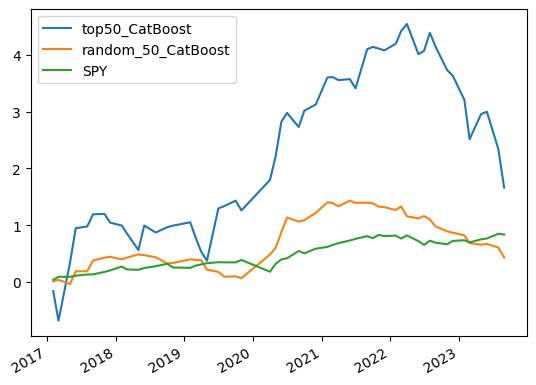

In [25]:

combined_APT  = pd.concat([top_50_APT.groupby('date')['stock_exret'].mean().rename('top50_CatBoost'),
                       rnd_50_APT.groupby('date')['stock_exret'].mean().rename('random_50_CatBoost'),
                       spy.rename('SPY'),rf],axis = 1).dropna()


combined  = pd.concat([top_50_APT.groupby('date')['stock_exret'].mean().rename('top50_CatBoost'),
                       rnd_50_APT.groupby('date')['stock_exret'].mean().rename('random_50_CatBoost'),
                       spy.rename('SPY'),rf],axis = 1).dropna()

# combined_APT['SPY'] = combined_APT['adjusted_close'].cumprod()

combined_APT[['top50_CatBoost', 'random_50_CatBoost','SPY']].cumsum().plot()

In [27]:
performance_statistics_APT = calculate_performance_statistics(combined_APT)
performance_statistics_APT

,SPY,top50_CatBoost,random_50_CatBoost
Alpha,0.000000,0.024800,0.012200
Sharpe Ratio,0.889835,0.276274,0.208495
Average Return,0.015536,0.030793,0.008038
Standard Deviation,0.055751,0.370869,0.113364
Maximum Drawdown,-0.207094,-2.880362,-0.998746
Maximum One-Month Loss,-0.207094,-0.693504,-0.174463
